In [1]:
# Setup imports
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from scipy.interpolate import make_interp_spline
import matplotlib.colors as mcolors

In [2]:
# Set rcParams for text size
plt.rcParams.update({
    'axes.labelsize': 20,
    'axes.titlesize': 20,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'figure.figsize': [6, 3],
    'legend.fontsize': 18,
    'legend.columnspacing': 2,
    'legend.handletextpad': 0.5,
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

In [3]:
# A function to read a log file for all lines containing a specific
# string. It should then create a list of tuples where each tuple is
# of the form (time_from_start_seconds, accuracy). String to find from
# the logfile is passed as an argument. It should return this list of
# tuples. It should also take the filename with path of the logfile
# as an argument.
def parse_log_file_ts_acc_values(filepath, search_string):
    result = []
    base_time = None

    with open(filepath, 'r') as file:
        for line in file:
            if not base_time:
                try:
                    # Attempt to extract the timestamp from the line
                    base_time = datetime.strptime(line.split(" | ")[0], "%Y-%m-%d %H:%M:%S,%f")
                except (ValueError, IndexError):
                    # Skip lines that don't have a valid timestamp
                    continue
            
            if search_string in line:
                parts = line.strip().split(" | ")
                timestamp = datetime.strptime(parts[0], "%Y-%m-%d %H:%M:%S,%f")
                time_from_start = (timestamp - base_time).total_seconds()
                
                # Extract the accuracy value from the last parenthesis
                accuracy_str = parts[-1].split("(")[-1].strip(")")
                accuracy = float(accuracy_str) * 100
                
                result.append((time_from_start, accuracy))
    
    return result

In [4]:
# Populate acc tuples from log files
log_file_dir = "/home/dgarg39/flame/lib/python/examples/async_cifar10/eurosys26_expts/agg_logs"

# Synthetic unavail 0% logs
# Oracular syn 0 was accidentally run with 0 unavail. Run deleted from
# wandb but logs exist.
oort_syn0_acc = parse_log_file_ts_acc_values(
    f"{log_file_dir}/agg_sheph_14_05_12_52_alpha0.1_cifar_70acc_fedavg_oort_unaware_syn_50.log", ", test accuracy:"
)
oort_oracular_syn0_acc = parse_log_file_ts_acc_values(
    f"{log_file_dir}/agg_wash_11_05_02_42_alpha0.1_cifar_70acc_fedavg_oort_oracular_syn0.log", ", test accuracy:"
)
oort_async_oracular_syn0_acc = parse_log_file_ts_acc_values(
    f"{log_file_dir}/agg_sheph_11_05_02_42_alpha0.1_cifar_70acc_fedbuff_oortAsync_oracular_syn0.log", ", test accuracy:"
)
felix_syn0_acc = parse_log_file_ts_acc_values(
    f"{log_file_dir}/agg_sheph_13_05_01_50_alpha0.1_cifar_70acc_TierFuse_TierSelect_TierTrack_syn_0.log", ", test accuracy:"
)

In [5]:
# Synthetic unavail 10% logs
oort_syn10_acc = parse_log_file_ts_acc_values(
    f"{log_file_dir}/agg_wash_14_05_21_15_alpha0.1_cifar_70acc_fedavg_oort_unaware_syn_20.log", ", test accuracy:"
)
oort_oracular_syn10_acc = parse_log_file_ts_acc_values(
    f"{log_file_dir}/agg_wash_11_05_11_49_alpha0.1_cifar_70acc_fedavg_oort_oracular_syn20.log", ", test accuracy:"
)
oort_async_oracular_syn10_acc = parse_log_file_ts_acc_values(
    f"{log_file_dir}/agg_jayne_11_05_15_20_alpha0.1_cifar_70acc_fedbuff_oortAsync_oracular_syn20.log", ", test accuracy:"
)
felix_syn10_acc = parse_log_file_ts_acc_values(
    f"{log_file_dir}/agg_sheph_13_05_08_29_alpha0.1_cifar_70acc_TierFuse_TierSelect_TierTrack_syn_20.log", ", test accuracy:"
)

In [6]:
# Synthetic unavail 50% logs
oort_syn50_acc = None
oort_oracular_syn50_acc = parse_log_file_ts_acc_values(
    f"{log_file_dir}/agg_wash_11_05_20_20_alpha0.1_cifar_70acc_fedavg_oort_oracular_syn50.log", ", test accuracy:"
)
oort_async_oracular_syn50_acc = parse_log_file_ts_acc_values(
    f"{log_file_dir}/agg_sheph_11_05_15_21_alpha0.1_cifar_70acc_fedbuff_oortAsync_oracular_syn50.log", ", test accuracy:"
)
felix_syn50_acc = parse_log_file_ts_acc_values(
    f"{log_file_dir}/agg_jayne_13_05_01_52_alpha0.1_cifar_70acc_TierFuse_TierSelect_TierTrack_syn_50.log", ", test accuracy:"
)

In [7]:
# Mobiperf logs
oort_mobiperf_acc = None
oort_oracular_mobiperf_acc = parse_log_file_ts_acc_values(
    f"{log_file_dir}/agg_wash_12_05_05_41_alpha0.1_cifar_70acc_fedavg_oort_oracular_mobiperf.log", ", test accuracy:"
)
oort_async_oracular_mobiperf_acc = parse_log_file_ts_acc_values(
    f"{log_file_dir}/agg_jayne_12_05_00_04_alpha0.1_cifar_70acc_fedbuff_oortAsync_oracular_mobiperf.log", ", test accuracy:"
)
felix_mobiperf_acc = parse_log_file_ts_acc_values(
    f"{log_file_dir}/agg_wash_13_05_01_51_alpha0.1_cifar_70acc_TierFuse_TierSelect_TierTrack_mobiperf_3st.log", ", test accuracy:"
)

In [179]:
# Define colors and markers for different strategies. There are two
# types of strategies. SOTA and naive improvements over SOTA. The sota
# strategies should be solid lines and the naive improvements should
# be dashed lines. The sota strategies are oort, fedbuff and felix.
# The naive improvements are oort_async and oort_trace. The colors
# are defined in the color list. The markers are defined in the marker
# list. The colors and markers are used to plot the lines in the
# graph. The colors of naive improvements are the same as the sota
# strategies. The markers are different.

# Define colors and markers
colors = {
    'oort': '#009E73',         # burnt orange
    'oort_async': 'maroon',      # teal green
    'oort_async_tierTrack': 'maroon',      # teal green
    'felix': 'royalblue',        # mid blue (variant of blue, like RColorBrewer's 'Royal Blue')
    'felix_selector': 'royalblue',
    'felix_evalSel': 'purple',
    'oort_async_oracular': 'deeppink',   # purplish pink (stands out but elegant)
    'oort_oracular': 'goldenrod',    # soft yellow
    'oort_selector': 'goldenrod'    # soft yellow
}

markers = {
    'oort': 'o',
    'oort_async': 's',
    'oort_async_tierTrack': 's',
    'felix': 'D',
    'felix_selector': 'D',
    'felix_evalSel': 'D',
    'oort_async_oracular': '^',
    'oort_oracular': 'v',
    'oort_selector': 'v'
}

line_styles = {
    'oort': 'solid',
    'oort_async': 'solid',
    'oort_async_tierTrack': 'solid',
    'felix': 'solid',
    'felix_selector': 'solid',
    'felix_evalSel': 'solid',
    'oort_async_oracular': 'solid',
    'oort_oracular': 'solid',
    'oort_selector': 'solid'
}

strategy_labels = {
    'oort': 'OORT',
    'oort_async': 'OORT+Async',
    'oort_async_tierTrack': 'OORT+Async(TierTrack)',
    'felix': 'FeLiX',
    'felix_selector': 'TrainSelect\n(FeLiX)',
    'felix_evalSel': 'EvalSelect\n(FeLiX)',
    'oort_async_oracular': 'OORT+Async*',
    'oort_oracular': 'OORT*',
    'oort_selector': 'TrainSelect\n(OORT)'
}

In [9]:
# Function to plot accuracy vs time graph. Skip the legend. The
# function should take two main inputs: first is a list of lists that
# contain the timestamp and accuracy tuples. The second is a list of
# strategies corresponding to the lists. The function should plot the
# accuracy vs time graph for each strategy.

def plot_accuracy_vs_time(
    data_lists, 
    strategies, 
    smooth=True, 
    marker_interval=600, 
    smoothing_method='savgol',  # or 'moving_average'
    window_size=101, 
    polyorder=2,  # for Savitzky–Golay
    plot_markers=True,
    xlim_hours=10,  # New: extend or shrink x-axis in hours
    filename="temp.pdf"
):
    strategy_to_time_accuracy = {}

    for data, strategy in zip(data_lists, strategies):
        if data is None:
            # Plot constant 10% line across the time range
            times = np.linspace(0, xlim_hours * 3600, 500)
            accuracies = np.full_like(times, 14.0)
            smoothed_times = times
            smoothed_accuracies = accuracies
        else:
            times, accuracies = zip(*data)
            accuracies = np.array(accuracies)
            times = np.array(times)

        if smooth:
            if smoothing_method == 'moving_average':
                smoothed_accuracies = np.convolve(
                    accuracies, np.ones(window_size) / window_size, mode='valid'
                )
                smoothed_times = times[:len(smoothed_accuracies)]
            elif smoothing_method == 'savgol':
                if window_size % 2 == 0:
                    window_size += 1
                if window_size > len(accuracies):
                    window_size = len(accuracies) if len(accuracies) % 2 == 1 else len(accuracies) - 1
                smoothed_accuracies = savgol_filter(accuracies, window_size, polyorder)
                smoothed_times = times
            else:
                raise ValueError("Invalid smoothing method. Use 'moving_average' or 'savgol'.")
        else:
            smoothed_accuracies = accuracies
            smoothed_times = times

        strategy_to_time_accuracy[strategy] = (smoothed_times, smoothed_accuracies)

        plt.plot(
            smoothed_times,
            smoothed_accuracies,
            label=strategy,
            color=colors[strategy],
            linestyle=line_styles[strategy],
            zorder=2
        )

        if plot_markers:
            marker_indices = range(0, len(smoothed_accuracies), marker_interval)
            plt.scatter(
                smoothed_times[marker_indices],
                smoothed_accuracies[marker_indices],
                color=colors[strategy],
                marker=markers[strategy],
                zorder=3
            )

    # Set grid
    plt.grid(True, color='gainsboro', zorder=1)

    # X-axis ticks and limits based on xlim_hours
    max_seconds = xlim_hours * 3600
    xticks = [3600 * h for h in range(0, xlim_hours + 1, 2)]
    xtick_labels = [str(h) for h in range(0, xlim_hours + 1, 2)]
    plt.xticks(xticks, xtick_labels)
    plt.xlim(0, max_seconds)
    plt.xlabel("Time Elapsed (hours)")
    plt.ylabel("Accuracy (%)")

    # Add 70% accuracy line
    plt.axhline(70, color='gray', linestyle='--', linewidth=2, zorder=1)
    # plt.text(max_seconds * 0.01, 62, "Target", fontsize=12, color='gray')

    # Add speedup arrow for 70% accuracy (if both strategies exist)
    if 'felix' in strategy_to_time_accuracy and 'oort_trace' in strategy_to_time_accuracy:
        def get_time_for_accuracy(times, accs, target_acc):
            for t, a in zip(times, accs):
                if a >= target_acc:
                    return t
            return None  # Not reached

        acc_target = 69.91
        felix_time_sec = get_time_for_accuracy(*strategy_to_time_accuracy['felix'], acc_target)
        oort_time_sec = get_time_for_accuracy(*strategy_to_time_accuracy['oort_trace'], acc_target)

        if felix_time_sec and oort_time_sec and oort_time_sec > felix_time_sec:
            # Convert to hours for x-axis
            felix_time_hr = felix_time_sec / 3600
            oort_time_hr = oort_time_sec / 3600

            # === Speedup arrow and annotation ===
            arrow_y = 60  # Vertical position of arrow
            text_y = arrow_y - 3  # Below the arrow for readability

            # Draw leftward arrow from oort → felix
            plt.annotate(
                '',
                xy=(oort_time_hr * 3600, arrow_y),
                xytext=(felix_time_hr * 3600, arrow_y),
                arrowprops=dict(
                    arrowstyle='<|-', 
                    color='black', 
                    linewidth=2,
                    shrinkA=5, shrinkB=5
                ),
                zorder=4
            )

            # Add bold speedup text centered below arrow
            speedup_factor = oort_time_sec / felix_time_sec
            mid_time_sec = ((felix_time_hr + oort_time_hr) / 2) * 3600
            plt.text(
                mid_time_sec, text_y,
                f"{speedup_factor:.2f}x\nspeedup",
                ha='center', va='top',
                fontsize=15, fontweight='bold', color='black'
            )

    # Auto-adjust ylim based on max accuracy
    all_accs = [acc for _, acc in strategy_to_time_accuracy.values()]
    max_acc = max([max(acc) for acc in all_accs])
    plt.ylim(10, 72)

    # plt.legend()
    plt.margins(0.5, 0.5)
    plt.tight_layout(pad=0)
    plt.savefig('/home/dgarg39/flame/lib/python/examples/async_cifar10/eurosys26_expts/plots/paper/'+filename, bbox_inches='tight', pad_inches=0)
    plt.show()


In [10]:
syn_0_acc_lists = [oort_syn0_acc, oort_oracular_syn0_acc, oort_async_oracular_syn0_acc, felix_syn0_acc]
syn_10_acc_lists = [oort_syn10_acc, oort_oracular_syn10_acc, oort_async_oracular_syn10_acc, felix_syn10_acc]
syn_50_acc_lists = [oort_syn50_acc, oort_oracular_syn50_acc, oort_async_oracular_syn50_acc, felix_syn50_acc]
mobiperf_acc_lists = [oort_mobiperf_acc, oort_oracular_mobiperf_acc, oort_async_oracular_mobiperf_acc, felix_mobiperf_acc]
syn_0_strategies = ['oort', 'oort_trace', 'oort_async', 'felix']
syn_10_strategies = ['oort', 'oort_trace', 'oort_async', 'felix']
syn_50_strategies = ['oort', 'oort_trace', 'oort_async', 'felix']
mobiperf_strategies = ['oort', 'oort_trace', 'oort_async', 'felix']

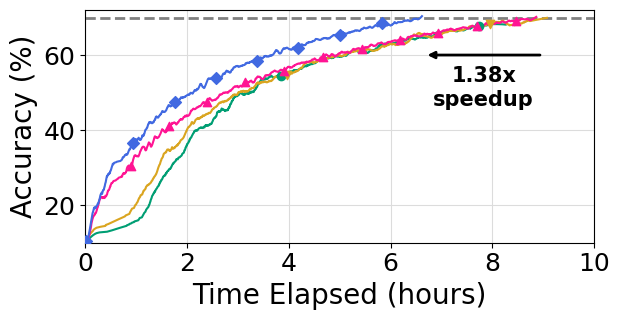

In [11]:
# Plotting the graphs
plot_accuracy_vs_time(
    syn_0_acc_lists, 
    syn_0_strategies,
    filename="cifar_syn0.pdf"
)

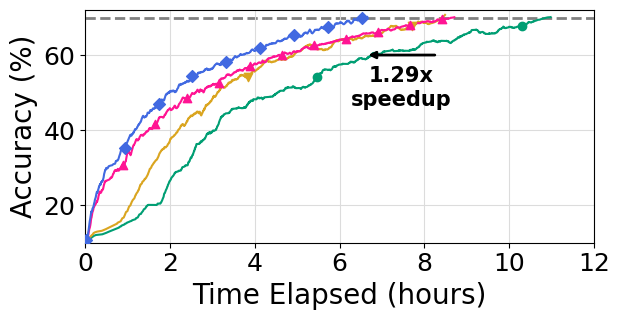

In [12]:
plot_accuracy_vs_time(syn_10_acc_lists, syn_10_strategies, xlim_hours=12, filename="cifar_syn10.pdf")

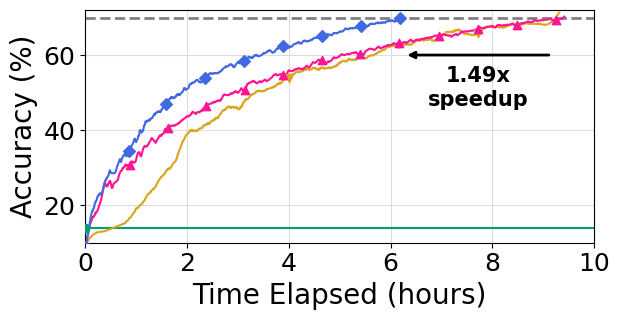

In [13]:
plot_accuracy_vs_time(syn_50_acc_lists, syn_50_strategies, filename="cifar_syn50.pdf")

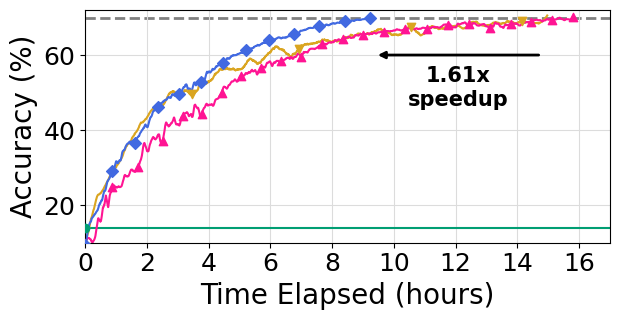

In [14]:
plot_accuracy_vs_time(mobiperf_acc_lists, mobiperf_strategies, xlim_hours=17, filename="cifar_mobiperf.pdf")

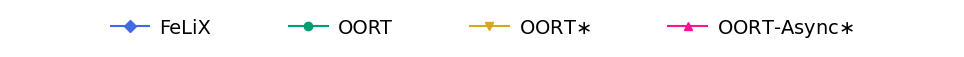

In [15]:
# Strategy display names (optional: tweak these for paper-style names)
strategy_labels = {
    'felix': 'FeLiX',
    'oort': 'OORT',
    'oort_trace': r'OORT$\ast$',
    # 'fedbuff': 'FedBuff',
    'oort_async': r'OORT-Async$\ast$'
}

# Plot dummy lines for legend only
plt.figure(figsize=(9.6, 0.4))
for strategy in strategy_labels:
    plt.plot([], [], linestyle=line_styles[strategy], marker=markers[strategy],
             color=colors[strategy], label=strategy_labels[strategy])

plt.axis('off')
plt.legend(
    fontsize=14, loc="center", frameon=False, ncols=len(strategy_labels),
    handletextpad=0.5, borderaxespad=0, columnspacing=4
)
plt.margins(0, 0)
plt.tight_layout(pad=0)
plt.savefig('/home/dgarg39/flame/lib/python/examples/async_cifar10/eurosys26_expts/plots/paper/legend_strategies.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [16]:
# Next we want to capture the communication overhead of each of the
# runs. This is split into 4 messages. Train messages sent from the
# aggregator to trainers, eval messages from aggregator to trainers.
# Weight messages from trainers to aggregator and the eval messages
# from trainers to aggregator. For each log file, return a dict with
# the count of each of these messages. The dict should be of the form
# {agg_train_sent: count, agg_eval_sent: count, agg_weight_recv:
# count, agg_eval_recv: count}. Example messages of each are of the
# form (1) agg_train_sent: "sending weights to <trainer_id> with
# model_version: <ver> for task: train", (2) agg_eval_sent: "sending
# weights to <trainer_id> with model_version: <ver> for task: eval",
# (3) agg_weight_recv: "Received weights from <trainer_id>. It was
# trained on model version <ver>" (4) agg_eval_recv: "received eval
# message"

def parse_communication_overhead(filepath):
    message_counts = {
        'agg_train_sent': 0,
        'agg_eval_sent': 0,
        'agg_weight_recv': 0,
        'agg_eval_recv': 0
    }

    with open(filepath, 'r') as file:
        for line in file:
            if "sending weights" in line and "task: train" in line:
                message_counts['agg_train_sent'] += 1
            elif "sending weights" in line and "task: eval" in line:
                message_counts['agg_eval_sent'] += 1
            elif "Received weights" in line and "trained on model version" in line:
                message_counts['agg_weight_recv'] += 1
            elif "received eval message" in line:
                message_counts['agg_eval_recv'] += 1
                
    # Handle the case for OORT aggregator exclusively. It doesnt count
    # received weight messages.
    if message_counts['agg_weight_recv'] == 0:
        message_counts['agg_weight_recv'] = message_counts['agg_train_sent'] - 13 # because 13 is the concurrency

    return message_counts

In [17]:
# Populate acc tuples from log files
log_file_dir = "/home/dgarg39/flame/lib/python/examples/async_cifar10/eurosys26_expts/agg_logs"

# Synthetic unavail 0% logs
oort_syn0_comm = parse_communication_overhead(
    f"{log_file_dir}/agg_sheph_14_05_12_52_alpha0.1_cifar_70acc_fedavg_oort_unaware_syn_50.log")
oort_oracular_syn0_comm = parse_communication_overhead(
    f"{log_file_dir}/agg_wash_11_05_02_42_alpha0.1_cifar_70acc_fedavg_oort_oracular_syn0.log")
oort_async_oracular_syn0_comm = parse_communication_overhead(
    f"{log_file_dir}/agg_sheph_11_05_02_42_alpha0.1_cifar_70acc_fedbuff_oortAsync_oracular_syn0.log")
felix_syn0_comm = parse_communication_overhead(
    f"{log_file_dir}/agg_sheph_13_05_01_50_alpha0.1_cifar_70acc_TierFuse_TierSelect_TierTrack_syn_0.log")

In [18]:
# Synthetic unavail 10% logs
oort_syn10_comm = parse_communication_overhead(
    f"{log_file_dir}/agg_wash_14_05_21_15_alpha0.1_cifar_70acc_fedavg_oort_unaware_syn_20.log")
oort_oracular_syn10_comm = parse_communication_overhead(
    f"{log_file_dir}/agg_wash_11_05_11_49_alpha0.1_cifar_70acc_fedavg_oort_oracular_syn20.log")
oort_async_oracular_syn10_comm = parse_communication_overhead(
    f"{log_file_dir}/agg_jayne_11_05_15_20_alpha0.1_cifar_70acc_fedbuff_oortAsync_oracular_syn20.log")
felix_syn10_comm = parse_communication_overhead(
    f"{log_file_dir}/agg_sheph_13_05_08_29_alpha0.1_cifar_70acc_TierFuse_TierSelect_TierTrack_syn_20.log")

In [19]:
# Synthetic unavail 50% logs
oort_syn50_comm = None
oort_oracular_syn50_comm = parse_communication_overhead(
    f"{log_file_dir}/agg_wash_11_05_20_20_alpha0.1_cifar_70acc_fedavg_oort_oracular_syn50.log")
oort_async_oracular_syn50_comm = parse_communication_overhead(
    f"{log_file_dir}/agg_sheph_11_05_15_21_alpha0.1_cifar_70acc_fedbuff_oortAsync_oracular_syn50.log")
felix_syn50_comm = parse_communication_overhead(
    f"{log_file_dir}/agg_jayne_13_05_01_52_alpha0.1_cifar_70acc_TierFuse_TierSelect_TierTrack_syn_50.log")

In [20]:
# Mobiperf logs
oort_mobiperf_comm = None
oort_oracular_mobiperf_comm = parse_communication_overhead(
    f"{log_file_dir}/agg_wash_12_05_05_41_alpha0.1_cifar_70acc_fedavg_oort_oracular_mobiperf.log")
oort_async_oracular_mobiperf_comm = parse_communication_overhead(
    f"{log_file_dir}/agg_jayne_12_05_00_04_alpha0.1_cifar_70acc_fedbuff_oortAsync_oracular_mobiperf.log")
felix_mobiperf_comm = parse_communication_overhead(
    f"{log_file_dir}/agg_wash_13_05_01_51_alpha0.1_cifar_70acc_TierFuse_TierSelect_TierTrack_mobiperf_3st.log")

In [21]:
oort_oracular_mobiperf_comm

{'agg_train_sent': 33229,
 'agg_eval_sent': 0,
 'agg_weight_recv': 33216,
 'agg_eval_recv': 0}

In [22]:
oort_async_oracular_syn0_comm

{'agg_train_sent': 69260,
 'agg_eval_sent': 0,
 'agg_weight_recv': 69230,
 'agg_eval_recv': 0}

In [23]:
felix_syn0_comm

{'agg_train_sent': 47884,
 'agg_eval_sent': 20371,
 'agg_weight_recv': 47855,
 'agg_eval_recv': 20371}

In [24]:
# Write a function to take two primary inputs. The first is a list of
# dictionaries that contain the communication overhead for each of the
# strategies. The second is a list of strategies corresponding to the
# dictionaries. The function should plot the communication overhead as
# a stacked bar graph and also print the total at the top. Each
# train_sent, eval_sent, weight_recv message counts as 1MB while
# eval_recv counts as 0.01MB. The total should be printed in GB upto 1
# decimal place. The base color should be the same as the color of the
# strategy. The function should also take the filename as an argument
# and save the plot with that name.



In [25]:
syn_0_comm_lists = [oort_syn0_comm, oort_oracular_syn0_comm, oort_async_oracular_syn0_comm, felix_syn0_comm]
syn_10_comm_lists = [oort_syn10_comm, oort_oracular_syn10_comm, oort_async_oracular_syn10_comm, felix_syn10_comm]
syn_50_comm_lists = [oort_syn50_comm, oort_oracular_syn50_comm, oort_async_oracular_syn50_comm, felix_syn50_comm]
mobiperf_comm_lists = [oort_mobiperf_comm, oort_oracular_mobiperf_comm, oort_async_oracular_mobiperf_comm, felix_mobiperf_comm]

syn_0_strategies = ['oort', 'oort_trace', 'oort_async', 'felix']
syn_10_strategies = ['oort', 'oort_trace', 'oort_async', 'felix']
syn_50_strategies = ['oort', 'oort_trace', 'oort_async', 'felix']
mobiperf_strategies = ['oort', 'oort_trace', 'oort_async', 'felix']

In [26]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1 - amount) with white.
    """
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    r, g, b, a = mcolors.to_rgba(c)
    return (r + (1 - r) * amount, g + (1 - g) * amount, b + (1 - b) * amount, a)

def plot_communication_overhead(comm_overhead_list, strategies, colors, strategy_labels, ylim_max=120, cross_mark_y_pos=30, filename="temp.pdf"):
    # Initialize components in MB
    train_sent_mb = []
    eval_sent_mb = []
    weight_recv_mb = []
    eval_recv_mb = []
    totals_gb = []
    eval_totals_gb = []
    weight_totals_gb = []

    for comm in comm_overhead_list:
        if comm is None:
            # Use small default MB values to show minimal bar
            train = 50     # e.g., 50MB for train
            eval_s = 0
            weight = 50    # 50MB for weight
            eval_r = 0
            show_as_less_than_1gb = True
        else:
            train = comm['agg_train_sent']
            eval_s = comm['agg_eval_sent']
            weight = comm['agg_weight_recv']
            eval_r = comm['agg_eval_recv'] * 0.01
            show_as_less_than_1gb = False

        train_sent_mb.append(train)
        eval_sent_mb.append(eval_s)
        weight_recv_mb.append(weight)
        eval_recv_mb.append(eval_r)

        total_mb = train + eval_s + weight + eval_r
        eval_total = eval_s + eval_r
        weight_total = train + weight

        totals_gb.append(total_mb / 1024)
        eval_totals_gb.append(eval_total / 1024)
        weight_totals_gb.append(weight_total / 1024)

    bar_positions = np.arange(len(strategies))

    # plt.figure(figsize=(10, 6))

    # Stack bars with color logic
    for i, strategy in enumerate(strategies):
        base_color = colors[strategy]
        eval_color = lighten_color(base_color, 0.5)

        bottom = 0
        train_gb = train_sent_mb[i] / 1024
        plt.bar(bar_positions[i], train_gb, color=base_color, label=None, zorder=2)
        bottom += train_gb

        weight_gb = weight_recv_mb[i] / 1024
        plt.bar(bar_positions[i], weight_gb, bottom=bottom, color=base_color, zorder=2)
        bottom += weight_gb

        eval_sent_gb = eval_sent_mb[i] / 1024
        plt.bar(bar_positions[i], eval_sent_gb, bottom=bottom, color=eval_color, zorder=2)
        bottom += eval_sent_gb

        eval_recv_gb = eval_recv_mb[i] / 1024
        plt.bar(bar_positions[i], eval_recv_gb, bottom=bottom, color=eval_color, zorder=2)
        bottom += eval_recv_gb

        # Total + breakdown annotation
        if comm_overhead_list[i] is None:
            # Print "Run failed" label
            plt.text(
                bar_positions[i], bottom + 3,
                "Stalls\nIndefinitely", ha='center', fontsize=12, fontweight='bold'
            )
            # Print red X above the "<1 GB"
            plt.text(
                bar_positions[i], cross_mark_y_pos,
                "X", ha='center', fontsize=16, fontweight='bold', color='red'
            )
        else:
            plt.text(
                bar_positions[i], bottom + 1,
                f"{totals_gb[i]:.1f} GB", ha='center', fontsize=12, fontweight='bold'
            )
        if comm_overhead_list[i] is not None:
            plt.text(
                bar_positions[i], 5,
                f"(W: {weight_totals_gb[i]:.1f},\nE: {eval_totals_gb[i]:.1f})",
                ha='center', fontsize=12
            )

    # X ticks
    plt.xticks(bar_positions, [strategy_labels[s] for s in strategies], fontsize=12)

    # Y axis in GB
    plt.ylabel("Communication (GB)", fontsize=14)
    plt.yticks(fontsize=12)

    # Legend for message types only
    weight_patch = plt.Rectangle((0, 0), 1, 1, color='gray', label='Weights Msgs')
    eval_patch = plt.Rectangle((0, 0), 1, 1, color='lightgray', label='Eval Msgs')
    plt.legend(
        handles=[weight_patch, eval_patch],
        labels=["Weights Msgs", "Eval Msgs"],
        fontsize=12, loc='upper left', frameon=False
    )
    plt.ylim(0, ylim_max)
    plt.grid(True, color='gainsboro', zorder=1)

    # Title and save
    # plt.title("Communication Overhead by Strategy", fontsize=16)
    plt.tight_layout()
    plt.savefig('/home/dgarg39/flame/lib/python/examples/async_cifar10/eurosys26_expts/plots/paper/'+filename, bbox_inches='tight', pad_inches=0)
    plt.show()

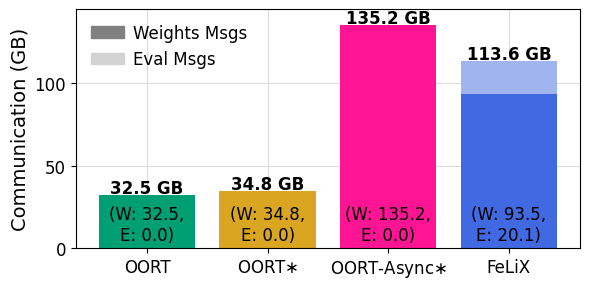

In [27]:
plot_communication_overhead(
    syn_0_comm_lists, 
    syn_0_strategies,
    colors=colors,
    strategy_labels=strategy_labels,
    ylim_max=145,
    filename="cifar_syn0_comm.pdf"
)

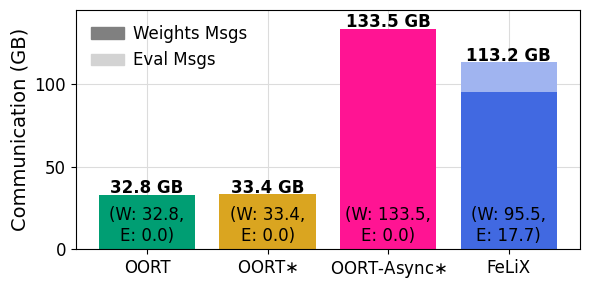

In [28]:
plot_communication_overhead(
    syn_10_comm_lists, 
    syn_10_strategies,
    colors=colors,
    strategy_labels=strategy_labels,
    ylim_max=145,
    filename="cifar_syn10_comm.pdf"
)

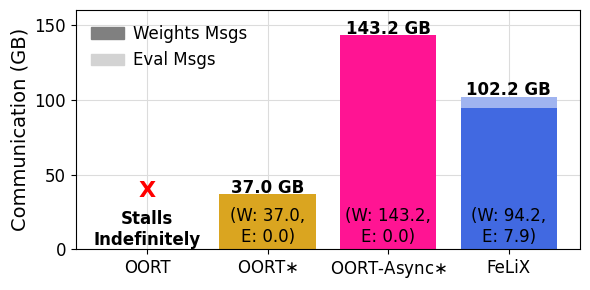

In [29]:
plot_communication_overhead(
    syn_50_comm_lists, 
    syn_50_strategies,
    colors=colors,
    strategy_labels=strategy_labels,
    ylim_max=160,
    cross_mark_y_pos=35,
    filename="cifar_syn50_comm.pdf"
)

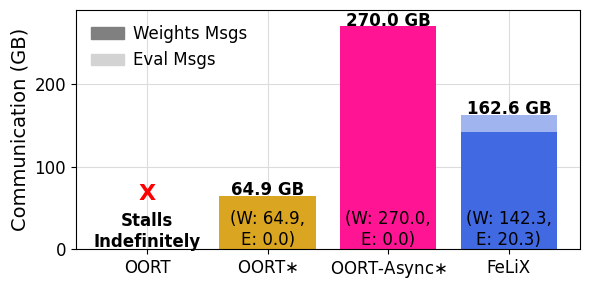

In [30]:
plot_communication_overhead(
    mobiperf_comm_lists, 
    mobiperf_strategies,
    colors=colors,
    strategy_labels=strategy_labels,
    ylim_max=290,
    cross_mark_y_pos=60,
    filename="cifar_mobiperf_comm.pdf"
)

In [148]:
import ast

# want to analyze the selector decisions for the strategies. First we
# understand the statistical utility of trainers picked by the
# different strategies over a period of the run. For each given log
# file, return a list of tuples where each tuple is of the form
# (time_from_start_seconds, utility). The time_from_start_seconds is
# the time from the start of the run in seconds. The utility is taken
# from the log line: "Train selector stats summary" which actually
# prints out the dict. We are interested in the key called
# "stat_util_last_200" which is also a dict. Within this dict we want
# the "p50" value. The function should take the filename with path of
# the logfile as an argument. The function should return a list of
# tuples.

import ast
from datetime import datetime

def parse_log_file_selector_util(filepath, task_name="Train"):
    result = []
    base_time = None

    with open(filepath, 'r') as file:
        for line in file:
            if f"{task_name} selector stats summary:" in line:
                try:
                    # Split line into timestamp and the dict
                    parts = line.strip().split(" | ")
                    timestamp_str = parts[0]
                    timestamp = datetime.strptime(timestamp_str, "%Y-%m-%d %H:%M:%S,%f")

                    # Set base_time on first valid timestamp
                    if base_time is None:
                        base_time = timestamp

                    # Extract dict string after the specific substring
                    dict_str_start = line.index(f"{task_name} selector stats summary:") + len(f"{task_name} selector stats summary:")
                    stats_dict_str = line[dict_str_start:].strip()

                    stats_dict = ast.literal_eval(stats_dict_str)
                    util_p50 = stats_dict["stat_util_last_200"]["p50"]

                    # Skip if None
                    if util_p50 is None:
                        continue

                    time_from_start = (timestamp - base_time).total_seconds()
                    result.append((time_from_start, util_p50))

                except (ValueError, IndexError, KeyError, SyntaxError):
                    continue  # Skip malformed lines
    return result

In [149]:
# Populate acc tuples from log files
log_file_dir = "/home/dgarg39/flame/lib/python/examples/async_cifar10/eurosys26_expts/agg_logs"

# Synthetic unavail 0% logs
oort_syn0_sel_util = parse_log_file_selector_util(
    f"{log_file_dir}/agg_sheph_14_05_12_52_alpha0.1_cifar_70acc_fedavg_oort_unaware_syn_50.log")
oort_oracular_syn0_sel_util = parse_log_file_selector_util(
    f"{log_file_dir}/agg_wash_11_05_02_42_alpha0.1_cifar_70acc_fedavg_oort_oracular_syn0.log")
oort_async_oracular_syn0_sel_util = parse_log_file_selector_util(
    f"{log_file_dir}/agg_sheph_11_05_02_42_alpha0.1_cifar_70acc_fedbuff_oortAsync_oracular_syn0.log")
felix_syn0_sel_util = parse_log_file_selector_util(
    f"{log_file_dir}/agg_sheph_13_05_01_50_alpha0.1_cifar_70acc_TierFuse_TierSelect_TierTrack_syn_0.log")

In [150]:
felix_syn0_sel_util

[(8.199, 112.08771532498808),
 (8.313, 112.08771532498808),
 (8.434, 112.08771532498808),
 (8.538, 112.08771532498808),
 (9.062, 112.08771532498808),
 (9.167, 112.08771532498808),
 (13.416, 130.8986822485392),
 (13.53, 130.8986822485392),
 (13.649, 130.8986822485392),
 (13.754, 130.8986822485392),
 (14.289, 130.8986822485392),
 (14.393, 130.8986822485392),
 (18.175, 138.60418759580028),
 (18.289, 138.60418759580028),
 (19.915, 131.02011654813978),
 (20.067, 131.02011654813978),
 (22.771, 138.60418759580028),
 (22.886, 138.60418759580028),
 (23.915, 138.60418759580028),
 (24.031, 138.60418759580028),
 (26.393, 146.67062981608217),
 (26.51, 146.67062981608217),
 (28.555, 142.7698431300404),
 (28.676, 142.7698431300404),
 (28.801, 142.7698431300404),
 (28.906, 142.7698431300404),
 (30.538, 146.67062981608217),
 (30.653, 146.67062981608217),
 (32.956, 146.67062981608217),
 (33.075, 146.67062981608217),
 (34.123, 172.90147944239243),
 (34.238, 172.90147944239243),
 (36.639, 166.951013500783

In [34]:
# Synthetic unavail 10% logs
oort_syn10_sel_util = parse_log_file_selector_util(
    f"{log_file_dir}/agg_wash_14_05_21_15_alpha0.1_cifar_70acc_fedavg_oort_unaware_syn_20.log")
oort_oracular_syn10_sel_util = parse_log_file_selector_util(
    f"{log_file_dir}/agg_wash_11_05_11_49_alpha0.1_cifar_70acc_fedavg_oort_oracular_syn20.log")
oort_async_oracular_syn10_sel_util = parse_log_file_selector_util(
    f"{log_file_dir}/agg_jayne_11_05_15_20_alpha0.1_cifar_70acc_fedbuff_oortAsync_oracular_syn20.log")
felix_syn10_sel_util = parse_log_file_selector_util(
    f"{log_file_dir}/agg_sheph_13_05_08_29_alpha0.1_cifar_70acc_TierFuse_TierSelect_TierTrack_syn_20.log")

In [35]:
# Synthetic unavail 50% logs
oort_syn50_sel_util = None
oort_oracular_syn50_sel_util = parse_log_file_selector_util(
    f"{log_file_dir}/agg_wash_11_05_20_20_alpha0.1_cifar_70acc_fedavg_oort_oracular_syn50.log")
oort_async_oracular_syn50_sel_util = parse_log_file_selector_util(
    f"{log_file_dir}/agg_sheph_11_05_15_21_alpha0.1_cifar_70acc_fedbuff_oortAsync_oracular_syn50.log")
felix_syn50_sel_util = parse_log_file_selector_util(
    f"{log_file_dir}/agg_jayne_13_05_01_52_alpha0.1_cifar_70acc_TierFuse_TierSelect_TierTrack_syn_50.log")

In [36]:
# Mobiperf logs
oort_mobiperf_sel_util = None
oort_oracular_mobiperf_sel_util = parse_log_file_selector_util(
    f"{log_file_dir}/agg_wash_12_05_05_41_alpha0.1_cifar_70acc_fedavg_oort_oracular_mobiperf.log")
oort_async_oracular_mobiperf_sel_util = parse_log_file_selector_util(
    f"{log_file_dir}/agg_jayne_12_05_00_04_alpha0.1_cifar_70acc_fedbuff_oortAsync_oracular_mobiperf.log")
felix_mobiperf_sel_util = parse_log_file_selector_util(
    f"{log_file_dir}/agg_wash_13_05_01_51_alpha0.1_cifar_70acc_TierFuse_TierSelect_TierTrack_mobiperf_3st.log")

In [37]:
syn_0_sel_util_lists = [oort_syn0_sel_util, oort_oracular_syn0_sel_util, oort_async_oracular_syn0_sel_util, felix_syn0_sel_util]
syn_10_sel_util_lists = [oort_syn10_sel_util, oort_oracular_syn10_sel_util, oort_async_oracular_syn10_sel_util, felix_syn10_sel_util]
syn_50_sel_util_lists = [oort_syn50_sel_util, oort_oracular_syn50_sel_util, oort_async_oracular_syn50_sel_util, felix_syn50_sel_util]
mobiperf_sel_util_lists = [oort_mobiperf_sel_util, oort_oracular_mobiperf_sel_util, oort_async_oracular_mobiperf_sel_util, felix_mobiperf_sel_util]

syn_0_strategies = ['oort', 'oort_trace', 'oort_async', 'felix']
syn_10_strategies = ['oort', 'oort_trace', 'oort_async', 'felix']
syn_50_strategies = ['oort', 'oort_trace', 'oort_async', 'felix']
mobiperf_strategies = ['oort', 'oort_trace', 'oort_async', 'felix']

In [38]:
# Write a function to plot selector utility of multiple baselines over
# time. The function should take two main inputs. The first is a list of
# lists that contain the timestamp and utility tuples. The second is a
# list of strategies corresponding to the lists. The function should
# plot the selector utility vs time graph for each strategy. The
# function should also take the filename as an argument and save the
# plot with that name. The function should also take the xlim_hours
# argument to set the x-axis limits in hours.

def plot_selector_util_vs_time(
    data_lists,
    strategies,
    filename="selector_util.pdf",
    xlim_hours=10,
    smooth=True,                # New: enable smoothing
    smoothing_method='savgol',   # 'savgol' or 'moving_average'
    window_size=101,
    polyorder=2
):
    for data, strategy in zip(data_lists, strategies):
        if data is None or len(data) == 0:
            continue
        times, utils = zip(*data)
        times = np.array(times)
        utils = np.array(utils)

        if smooth and len(utils) > 2:
            if smoothing_method == 'moving_average':
                if window_size > len(utils):
                    window_size = len(utils)
                smoothed_utils = np.convolve(utils, np.ones(window_size) / window_size, mode='valid')
                smoothed_times = times[:len(smoothed_utils)]
            elif smoothing_method == 'savgol':
                if window_size % 2 == 0:
                    window_size += 1
                if window_size > len(utils):
                    window_size = len(utils) if len(utils) % 2 == 1 else len(utils) - 1
                smoothed_utils = savgol_filter(utils, window_size, polyorder)
                smoothed_times = times
            else:
                raise ValueError("Invalid smoothing method. Use 'moving_average' or 'savgol'.")
        else:
            smoothed_utils = utils
            smoothed_times = times

        plt.plot(
            smoothed_times,
            smoothed_utils,
            label=strategy_labels.get(strategy, strategy),
            color=colors[strategy],
            linestyle=line_styles[strategy],
            marker=markers[strategy],
            markevery=max(len(smoothed_times)//10, 1),
            zorder=2
        )

    plt.xlabel("Time Elapsed (seconds)")
    plt.ylabel("Sel. Stat. Util. (p50)")
    plt.xlim(0, xlim_hours * 3600)
    plt.grid(True, color='gainsboro', zorder=1)
    plt.tight_layout()
    plt.savefig('/home/dgarg39/flame/lib/python/examples/async_cifar10/eurosys26_expts/plots/paper/' + filename, bbox_inches='tight', pad_inches=0)
    plt.show()

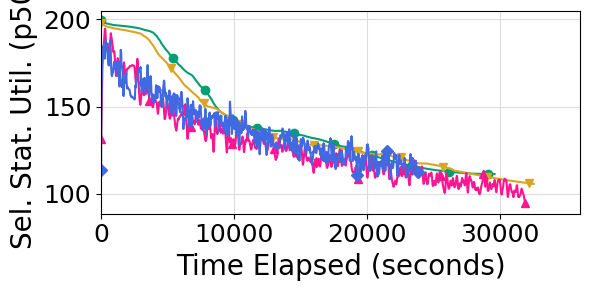

In [39]:
plot_selector_util_vs_time(
    syn_0_sel_util_lists,
    syn_0_strategies,
    filename="cifar_syn0_selector_util.pdf",
    xlim_hours=10
)

In [172]:
def plot_selector_util_cdf(
    data_lists,
    strategies,
    filename="selector_util_cdf.pdf"
):
    # Prepare p50 values for annotation
    p50_annotations = []
    for idx, (data, strategy) in enumerate(zip(data_lists, strategies)):
        if data is None or len(data) == 0:
            continue

        _, utils = zip(*data)
        utils = np.array(utils)
        utils = utils[~np.isnan(utils)]  # remove NaNs if any

        sorted_utils = np.sort(utils)
        cdf = np.linspace(0, 1, len(sorted_utils))

        plt.plot(
            sorted_utils,
            cdf,
            label=strategy_labels.get(strategy, strategy),
            color=colors[strategy],
            linestyle=line_styles[strategy],
            marker=markers[strategy],
            markevery=max(len(cdf)//10, 1),
            zorder=2
        )

        # Collect p50 for annotation
        p50 = np.percentile(sorted_utils, 50)
        p50_annotations.append((p50, strategy))

    # Sort annotations by p50 descending
    p50_annotations.sort(reverse=True)

    # Annotate all p50s at bottom right
    xlim = plt.xlim()
    ylim = plt.ylim()
    x_annot = xlim[1] - 0.02 * (xlim[1] - xlim[0])
    y_start = ylim[0] + 0.10 * (ylim[1] - ylim[0])
    y_step = 0.3 * (ylim[1] - ylim[0])

    for i, (p50, strategy) in enumerate(p50_annotations):
        plt.text(
            x_annot, y_start + i * y_step,
            f"{strategy_labels.get(strategy, strategy)}: {p50:.1f}",
            color=colors[strategy],
            fontsize=14,
            fontweight='bold',
            ha='right',
            va='bottom'
        )

    plt.xlabel("Selected Trainer Stat. Util.")
    plt.ylabel("CDF")
    plt.grid(True, color='gainsboro', zorder=1)
    # plt.legend()
    plt.tight_layout()
    plt.savefig(
        '/home/dgarg39/flame/lib/python/examples/async_cifar10/eurosys26_expts/plots/paper/' + filename,
        bbox_inches='tight', pad_inches=0
    )
    plt.show()

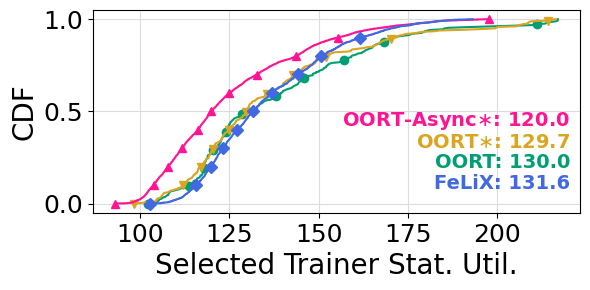

In [98]:
plot_selector_util_cdf(
    syn_10_sel_util_lists,
    syn_10_strategies,
    filename="cifar_syn10_selector_util_cdf.pdf",
)

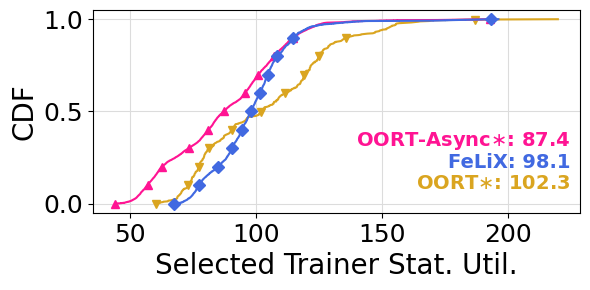

In [99]:
plot_selector_util_cdf(
    mobiperf_sel_util_lists,
    mobiperf_strategies,
    filename="cifar_mobiperf_selector_util_cdf.pdf",
)

In [151]:
import ast
from datetime import datetime

def parse_log_file_selector_speed(filepath, task_name="Train"):
    result = []
    base_time = None

    with open(filepath, 'r') as file:
        for line in file:
            if f"{task_name} selector stats summary:" in line:
                try:
                    # Split line into timestamp and the dict
                    parts = line.strip().split(" | ")
                    timestamp_str = parts[0]
                    timestamp = datetime.strptime(timestamp_str, "%Y-%m-%d %H:%M:%S,%f")

                    # Set base_time on first valid timestamp
                    if base_time is None:
                        base_time = timestamp

                    # Extract dict string after the specific substring
                    dict_str_start = line.index(f"{task_name} selector stats summary:") + len(f"{task_name} selector stats summary:")
                    stats_dict_str = line[dict_str_start:].strip()

                    stats_dict = ast.literal_eval(stats_dict_str)
                    util_p50 = stats_dict["speed_last_200"]["p50"]

                    # Skip if None
                    if util_p50 is None:
                        continue

                    time_from_start = (timestamp - base_time).total_seconds()
                    result.append((time_from_start, util_p50))

                except (ValueError, IndexError, KeyError, SyntaxError):
                    continue  # Skip malformed lines
    return result

In [77]:
# Populate acc tuples from log files
log_file_dir = "/home/dgarg39/flame/lib/python/examples/async_cifar10/eurosys26_expts/agg_logs"

# Synthetic unavail 0% logs
oort_syn0_speed = parse_log_file_selector_speed(
    f"{log_file_dir}/agg_sheph_14_05_12_52_alpha0.1_cifar_70acc_fedavg_oort_unaware_syn_50.log")
oort_oracular_syn0_speed = parse_log_file_selector_speed(
    f"{log_file_dir}/agg_wash_11_05_02_42_alpha0.1_cifar_70acc_fedavg_oort_oracular_syn0.log")
oort_async_oracular_syn0_speed = parse_log_file_selector_speed(
    f"{log_file_dir}/agg_sheph_11_05_02_42_alpha0.1_cifar_70acc_fedbuff_oortAsync_oracular_syn0.log")
felix_syn0_speed = parse_log_file_selector_speed(
    f"{log_file_dir}/agg_sheph_13_05_01_50_alpha0.1_cifar_70acc_TierFuse_TierSelect_TierTrack_syn_0.log")

In [46]:
# Synthetic unavail 10% logs
oort_syn10_speed = parse_log_file_selector_speed(
    f"{log_file_dir}/agg_wash_14_05_21_15_alpha0.1_cifar_70acc_fedavg_oort_unaware_syn_20.log")
oort_oracular_syn10_speed = parse_log_file_selector_speed(
    f"{log_file_dir}/agg_wash_11_05_11_49_alpha0.1_cifar_70acc_fedavg_oort_oracular_syn20.log")
oort_async_oracular_syn10_speed = parse_log_file_selector_speed(
    f"{log_file_dir}/agg_jayne_11_05_15_20_alpha0.1_cifar_70acc_fedbuff_oortAsync_oracular_syn20.log")
felix_syn10_speed = parse_log_file_selector_speed(
    f"{log_file_dir}/agg_sheph_13_05_08_29_alpha0.1_cifar_70acc_TierFuse_TierSelect_TierTrack_syn_20.log")

In [47]:
# Synthetic unavail 50% logs
oort_syn50_speed = None
oort_oracular_syn50_speed = parse_log_file_selector_speed(
    f"{log_file_dir}/agg_wash_11_05_20_20_alpha0.1_cifar_70acc_fedavg_oort_oracular_syn50.log")
oort_async_oracular_syn50_speed = parse_log_file_selector_speed(
    f"{log_file_dir}/agg_sheph_11_05_15_21_alpha0.1_cifar_70acc_fedbuff_oortAsync_oracular_syn50.log")
felix_syn50_speed = parse_log_file_selector_speed(
    f"{log_file_dir}/agg_jayne_13_05_01_52_alpha0.1_cifar_70acc_TierFuse_TierSelect_TierTrack_syn_50.log")

In [48]:
# Mobiperf logs
oort_mobiperf_speed = None
oort_oracular_mobiperf_speed = parse_log_file_selector_speed(
    f"{log_file_dir}/agg_wash_12_05_05_41_alpha0.1_cifar_70acc_fedavg_oort_oracular_mobiperf.log")
oort_async_oracular_mobiperf_speed = parse_log_file_selector_speed(
    f"{log_file_dir}/agg_jayne_12_05_00_04_alpha0.1_cifar_70acc_fedbuff_oortAsync_oracular_mobiperf.log")
felix_mobiperf_speed = parse_log_file_selector_speed(
    f"{log_file_dir}/agg_wash_13_05_01_51_alpha0.1_cifar_70acc_TierFuse_TierSelect_TierTrack_mobiperf_3st.log")

In [50]:
syn_0_speed_lists = [oort_syn0_speed, oort_oracular_syn0_speed, oort_async_oracular_syn0_speed, felix_syn0_speed]
syn_10_speed_lists = [oort_syn10_speed, oort_oracular_syn10_speed, oort_async_oracular_syn10_speed, felix_syn10_speed]
syn_50_speed_lists = [oort_syn50_speed, oort_oracular_syn50_speed, oort_async_oracular_syn50_speed, felix_syn50_speed]
mobiperf_speed_lists = [oort_mobiperf_speed, oort_oracular_mobiperf_speed, oort_async_oracular_mobiperf_speed, felix_mobiperf_speed]

syn_0_strategies = ['oort', 'oort_trace', 'oort_async', 'felix']
syn_10_strategies = ['oort', 'oort_trace', 'oort_async', 'felix']
syn_50_strategies = ['oort', 'oort_trace', 'oort_async', 'felix']
mobiperf_strategies = ['oort', 'oort_trace', 'oort_async', 'felix']

In [ ]:
def plot_selector_speed_cdf(
    data_lists,
    strategies,
    filename="selector_speed_cdf.pdf",
):
    # Prepare p50 values for annotation
    p50_annotations = []
    for data, strategy in zip(data_lists, strategies):
        if data is None or len(data) == 0:
            continue

        _, utils = zip(*data)
        utils = np.array(utils)
        utils = utils[~np.isnan(utils)]  # remove NaNs if any

        sorted_utils = np.sort(utils)
        cdf = np.linspace(0, 1, len(sorted_utils))

        plt.plot(
            sorted_utils,
            cdf,
            label=strategy_labels.get(strategy, strategy),
            color=colors[strategy],
            linestyle=line_styles[strategy],
            marker=markers[strategy],
            markevery=max(len(cdf)//10, 1),
            zorder=2
        )

        # Collect p50 for annotation
        p50 = np.percentile(sorted_utils, 50)
        p50_annotations.append((p50, strategy))

    # Sort annotations by p50 descending
    p50_annotations.sort(reverse=True)

    # Annotate all p50s at bottom right
    xlim = plt.xlim()
    ylim = plt.ylim()
    x_annot = xlim[1] - 0.02 * (xlim[1] - xlim[0])
    y_start = ylim[0] + 0.10 * (ylim[1] - ylim[0])
    y_step = 0.1 * (ylim[1] - ylim[0])

    for i, (p50, strategy) in enumerate(p50_annotations):
        plt.text(
            x_annot, y_start + i * y_step,
            f"{strategy_labels.get(strategy, strategy)}: {p50:.1f}",
            color=colors[strategy],
            fontsize=14,
            fontweight='bold',
            ha='right',
            va='bottom'
        )

    plt.xlabel("Selected Trainer Speed (s)")
    plt.ylabel("CDF")
    plt.grid(True, color='gainsboro', zorder=1)
    # plt.legend()
    plt.tight_layout()
    plt.savefig(
        '/home/dgarg39/flame/lib/python/examples/async_cifar10/eurosys26_expts/plots/paper/' + filename,
        bbox_inches='tight', pad_inches=0
    )
    plt.show()

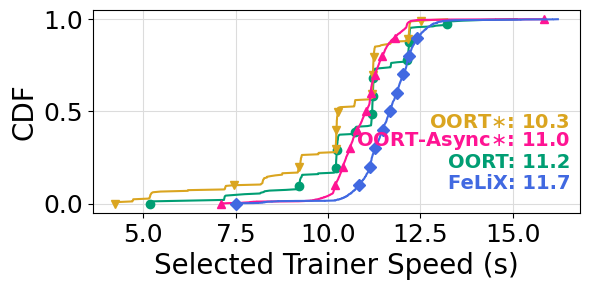

In [95]:
plot_selector_speed_cdf(
    syn_10_speed_lists,
    syn_10_strategies,
    filename="cifar_syn10_selector_speed_cdf.pdf",
)

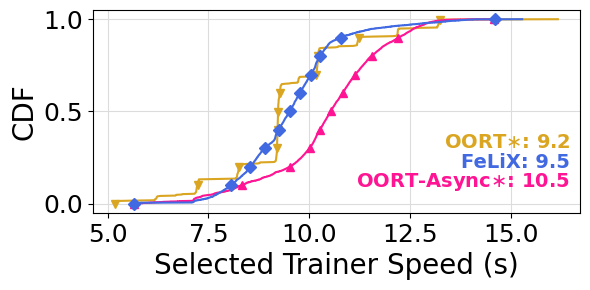

In [96]:
plot_selector_speed_cdf(
    mobiperf_speed_lists,
    mobiperf_strategies,
    filename="cifar_mobiperf_selector_speed_cdf.pdf",
)

#### Timeline plot for showing the benefits of TierTrack over oracular

In [100]:
# TierTrack:
# agg_sheph_13_05_15_20_alpha0.1_cifar_70acc_FedBuff_OORT_TierTrack_syn_50.log

# Oracular:
# agg_sheph_11_05_15_21_alpha0.1_cifar_70acc_fedbuff_oortAsync_oracular_syn50.log

oortAsync_oracular_syn50_acc = parse_log_file_ts_acc_values(
    f"{log_file_dir}/agg_sheph_11_05_15_21_alpha0.1_cifar_70acc_fedbuff_oortAsync_oracular_syn50.log", ", test accuracy:"
)
oortAsync_tierTrack_syn50_acc = parse_log_file_ts_acc_values(
    f"{log_file_dir}/agg_sheph_13_05_15_20_alpha0.1_cifar_70acc_FedBuff_OORT_TierTrack_syn_50.log", ", test accuracy:"
)

In [145]:
oortAsync_abl_tierTrack_syn50_acc_lists = [oortAsync_oracular_syn50_acc, oortAsync_tierTrack_syn50_acc]
oortAsync_abl_tierTrack_syn50_strategies = ['oort_async_oracular', 'oort_async_tierTrack']

In [146]:
def plot_accuracy_zoomed(
    data_lists,
    strategies,
    smooth=True,
    marker_interval=600,
    smoothing_method='savgol',
    window_size=101,
    polyorder=2,
    plot_markers=True,
    x_range=(18000, 35000),  # in seconds, e.g., (0, 36000) for 0–10 hours
    y_range=(58, 71),    # in accuracy %, e.g., (40, 70)
    filename="zoomed.pdf"
):
    strategy_to_time_accuracy = {}

    for data, strategy in zip(data_lists, strategies):
        if data is None:
            # Plot constant 10% line across the x_range
            times = np.linspace(x_range[0], x_range[1], 500)
            accuracies = np.full_like(times, 14.0)
        else:
            times, accuracies = zip(*data)
            accuracies = np.array(accuracies)
            times = np.array(times)

        # Smooth
        if smooth:
            if smoothing_method == 'moving_average':
                smoothed_accuracies = np.convolve(
                    accuracies, np.ones(window_size) / window_size, mode='valid'
                )
                smoothed_times = times[:len(smoothed_accuracies)]
            elif smoothing_method == 'savgol':
                if window_size % 2 == 0:
                    window_size += 1
                if window_size > len(accuracies):
                    window_size = len(accuracies) if len(accuracies) % 2 == 1 else len(accuracies) - 1
                smoothed_accuracies = savgol_filter(accuracies, window_size, polyorder)
                smoothed_times = times
            else:
                raise ValueError("Invalid smoothing method.")
        else:
            smoothed_accuracies = accuracies
            smoothed_times = times

        # Filter data within x_range
        mask = (smoothed_times >= x_range[0]) & (smoothed_times <= x_range[1])
        smoothed_times = smoothed_times[mask]
        smoothed_accuracies = smoothed_accuracies[mask]

        strategy_to_time_accuracy[strategy] = (smoothed_times, smoothed_accuracies)

        plt.plot(
            smoothed_times,
            smoothed_accuracies,
            label=strategy_labels[strategy],
            color=colors[strategy],
            linestyle=line_styles[strategy],
            zorder=2
        )

        if plot_markers:
            marker_indices = range(0, len(smoothed_accuracies), marker_interval)
            plt.scatter(
                smoothed_times[marker_indices],
                smoothed_accuracies[marker_indices],
                color=colors[strategy],
                marker=markers[strategy],
                zorder=3
            )

    plt.grid(True, color='gainsboro', zorder=1)
    plt.xlabel("Time Elapsed (hours)")
    plt.ylabel("Accuracy (%)")

    # x-axis: convert to hour scale for ticks
    x_ticks_sec = np.linspace(x_range[0], x_range[1], 5)
    x_tick_labels = [f"{t//3600:.1f}" for t in x_ticks_sec]
    plt.xticks(x_ticks_sec, x_tick_labels)
    plt.xlim(x_range)
    plt.ylim(y_range)

    plt.axhline(70, color='gray', linestyle='--', linewidth=2, zorder=1)
    plt.legend()

    plt.margins(0.5, 0.5)
    plt.tight_layout(pad=0)
    plt.savefig(
        '/home/dgarg39/flame/lib/python/examples/async_cifar10/eurosys26_expts/plots/paper/' + filename,
        bbox_inches='tight', pad_inches=0
    )
    plt.show()


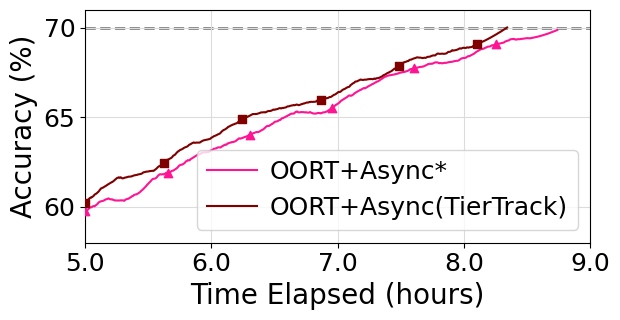

In [147]:
plot_accuracy_zoomed(oortAsync_abl_tierTrack_syn50_acc_lists, oortAsync_abl_tierTrack_syn50_strategies, filename="cifar_abl_tierTrack_syn50_oortAsync.pdf",
                      window_size=401)

### Ablation TierSelect
#### Plot 1: How train selector changes with and without eval selector (5% slowdown)
#### Plot 2: Different speed and stat util of clients that train selector and eval selector work on

In [ ]:
# Felix WITH EvalSelector
# agg_wash_13_05_13_19_alpha0.1_cifar_70acc_FedBuff_TierSelect_TierTrack_syn_50.log

# Felix WITHOUT EvalSelector
# agg_sheph_13_05_15_20_alpha0.1_cifar_70acc_FedBuff_OORT_TierTrack_syn_50.log

In [152]:
## TRAIN SELECTOR STATS
noEvalSelect_syn50_trainSel_util = parse_log_file_selector_util(
    f"{log_file_dir}/agg_sheph_13_05_15_20_alpha0.1_cifar_70acc_FedBuff_OORT_TierTrack_syn_50.log")

evalSelect_syn50_trainSel_util = parse_log_file_selector_util(
    f"{log_file_dir}/agg_wash_13_05_13_19_alpha0.1_cifar_70acc_FedBuff_TierSelect_TierTrack_syn_50.log")

noEvalSelect_syn50_trainSel_speed = parse_log_file_selector_speed(
    f"{log_file_dir}/agg_sheph_13_05_15_20_alpha0.1_cifar_70acc_FedBuff_OORT_TierTrack_syn_50.log")

evalSelect_syn50_trainSel_speed = parse_log_file_selector_speed(
    f"{log_file_dir}/agg_wash_13_05_13_19_alpha0.1_cifar_70acc_FedBuff_TierSelect_TierTrack_syn_50.log")

In [153]:
## EVAL SELECTOR STATS
evalSelect_syn50_evalSel_util = parse_log_file_selector_util(
    f"{log_file_dir}/agg_wash_13_05_13_19_alpha0.1_cifar_70acc_FedBuff_TierSelect_TierTrack_syn_50.log",
    task_name="Eval")

evalSelect_syn50_evalSel_speed = parse_log_file_selector_speed(
    f"{log_file_dir}/agg_wash_13_05_13_19_alpha0.1_cifar_70acc_FedBuff_TierSelect_TierTrack_syn_50.log",
    task_name="Eval")

In [158]:
evalSelect_syn50_trainSel_util

[(7.97, 110.94067127300374),
 (8.082, 110.94067127300374),
 (8.204, 110.94067127300374),
 (8.309, 110.94067127300374),
 (13.136, 128.17593637559185),
 (13.249, 128.17593637559185),
 (13.592, 128.17593637559185),
 (13.698, 128.17593637559185),
 (17.946, 146.6053428546704),
 (18.056, 146.6053428546704),
 (19.754, 131.15710169911793),
 (19.868, 131.15710169911793),
 (19.992, 131.15710169911793),
 (20.096, 131.15710169911793),
 (22.629, 154.89756241744396),
 (22.739, 154.89756241744396),
 (24.801, 154.89756241744396),
 (24.917, 154.89756241744396),
 (25.041, 154.89756241744396),
 (25.146, 154.89756241744396),
 (26.186, 146.6053428546704),
 (26.299, 146.6053428546704),
 (28.565, 146.6053428546704),
 (28.675, 146.6053428546704),
 (30.2, 142.86680511651923),
 (30.315, 142.86680511651923),
 (32.75, 142.86680511651923),
 (32.861, 142.86680511651923),
 (34.358, 139.12826737836804),
 (34.473, 139.12826737836804),
 (37.789, 142.86680511651923),
 (37.903, 142.86680511651923),
 (38.995, 154.89756241

In [161]:
tierSel_abl_train_sel_util_lists = [noEvalSelect_syn50_trainSel_util, evalSelect_syn50_trainSel_util]
tierSel_abl_train_sel_util_strategies = ['oort_selector', 'felix_selector']

tierSel_abl_train_sel_speed_lists = [noEvalSelect_syn50_trainSel_speed, evalSelect_syn50_trainSel_speed]
tierSel_abl_train_sel_speed_strategies = ['oort_selector', 'felix_selector']

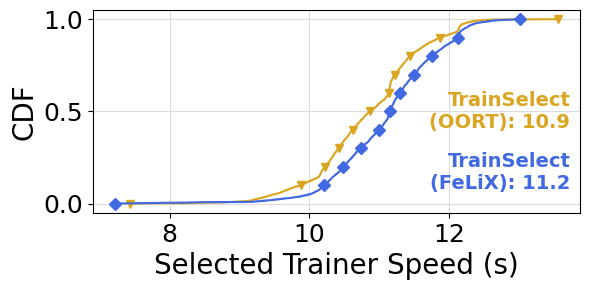

In [170]:
plot_selector_speed_cdf(
    tierSel_abl_train_sel_speed_lists,
    tierSel_abl_train_sel_speed_strategies,
    filename="cifar_syn50_tierSel_abl_trainSel_speed_cdf.pdf",
)

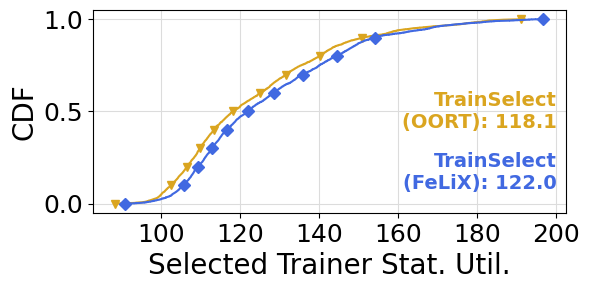

In [173]:
plot_selector_util_cdf(
    tierSel_abl_train_sel_util_lists,
    tierSel_abl_train_sel_util_strategies,
    filename="cifar_syn50_tierSel_abl_trainSel_util_cdf.pdf",
)

In [175]:
tierSel_abl_train_eval_sel_util_lists = [evalSelect_syn50_evalSel_util, evalSelect_syn50_trainSel_util]
tierSel_abl_train_eval_sel_util_strategies = ['felix_evalSel', 'felix_selector']

tierSel_abl_train_eval_sel_speed_lists = [evalSelect_syn50_evalSel_speed, evalSelect_syn50_trainSel_speed]
tierSel_abl_train_eval_sel_speed_strategies = ['felix_evalSel', 'felix_selector']

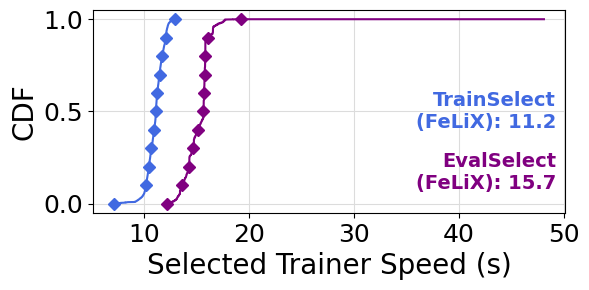

In [180]:
plot_selector_speed_cdf(
    tierSel_abl_train_eval_sel_speed_lists,
    tierSel_abl_train_eval_sel_speed_strategies,
    filename="cifar_syn50_tierSel_abl_trainSel_evalSel_speed_cdf.pdf",
)

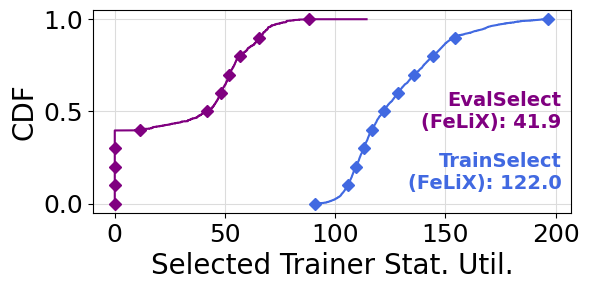

In [181]:
plot_selector_util_cdf(
    tierSel_abl_train_eval_sel_util_lists,
    tierSel_abl_train_eval_sel_util_strategies,
    filename="cifar_syn50_tierSel_abl_trainSel_evalSel_util_cdf.pdf",
)

### Ablation for TierFuse
#### Plot 1: it will be a 3 row 2 column plot
1st row: staleness cdf
2nd row: statistical utility cdf
3rd row: contribution weight cdf

In [ ]:
### No TierFuse: agg_wash_13_05_13_19_alpha0.1_cifar_70acc_FedBuff_TierSelect_TierTrack_syn_50.log
# "agg ver: 1, trainer ver: 1, trainer stat_utility: 193.21395219142485, rate: 1.0, with agg_rate_type: {'type': 'old'}"


### With TierFuse: agg_jayne_13_05_01_52_alpha0.1_cifar_70acc_TierFuse_TierSelect_TierTrack_syn_50.log
# "agg ver: 1, trainer ver: 1, trainer stat_utility: 193.6423989236791, rate: 0.945817168531056, with agg_rate_type: {'type': 'new', 'scale': 0.4, 'a_exp': 0.25, 'b_exp': 0.1}"

In [182]:
import re

def parse_log_file_for_aggregation_stats(filepath):
    staleness_list = []
    stat_utility_list = []
    rate_list = []

    pattern = re.compile(
        r"agg ver: (\d+), trainer ver: (\d+), trainer stat_utility: ([\d\.eE+-]+), rate: ([\d\.eE+-]+)"
    )

    with open(filepath, 'r') as f:
        for line in f:
            match = pattern.search(line)
            if match:
                agg_ver = int(match.group(1))
                trainer_ver = int(match.group(2))
                stat_utility = float(match.group(3))
                rate = float(match.group(4))

                staleness = agg_ver - trainer_ver

                staleness_list.append(staleness)
                stat_utility_list.append(stat_utility)
                rate_list.append(rate)

    return staleness_list, stat_utility_list, rate_list


In [183]:
fedbuff_staleness_list, fedbuff_stat_utility_list, fedbuff_rate_list = parse_log_file_for_aggregation_stats(
    f"{log_file_dir}/agg_wash_13_05_13_19_alpha0.1_cifar_70acc_FedBuff_TierSelect_TierTrack_syn_50.log"
)

tierfuse_staleness_list, tierfuse_stat_utility_list, tierfuse_rate_list = parse_log_file_for_aggregation_stats(
    f"{log_file_dir}/agg_jayne_13_05_01_52_alpha0.1_cifar_70acc_TierFuse_TierSelect_TierTrack_syn_50.log"
)

In [189]:
len(fedbuff_rate_list)

74705

In [190]:
def plot_cdf_metrics(
    data_lists_staleness,
    data_lists_statutil,
    data_lists_rate,
    strategies,
    filename_prefix="tierfuse_abl_cdf"
):
    def plot_single_cdf(data_lists, ylabel, filename):
        p50_annotations = []

        for data, strategy in zip(data_lists, strategies):
            if data is None or len(data) == 0:
                continue

            data = np.array(data)
            data = data[~np.isnan(data)]  # remove NaNs if any

            sorted_data = np.sort(data)
            cdf = np.linspace(0, 1, len(sorted_data))

            plt.plot(
                sorted_data,
                cdf,
                label=strategy_labels.get(strategy, strategy),
                color=colors[strategy],
                linestyle=line_styles[strategy],
                marker=markers[strategy],
                markevery=max(len(cdf)//10, 1),
                zorder=2
            )

            # p50
            p50 = np.percentile(sorted_data, 50)
            p50_annotations.append((p50, strategy))

        # Sort p50 annotations and place text
        p50_annotations.sort(reverse=True)
        xlim = plt.xlim()
        ylim = plt.ylim()
        x_annot = xlim[1] - 0.02 * (xlim[1] - xlim[0])
        y_start = ylim[0] + 0.10 * (ylim[1] - ylim[0])
        y_step = 0.1 * (ylim[1] - ylim[0])

        for i, (p50, strategy) in enumerate(p50_annotations):
            print(f"[{ylabel}] {strategy_labels.get(strategy, strategy)} p50: {p50:.2f}")
            plt.text(
                x_annot, y_start + i * y_step,
                f"{strategy_labels.get(strategy, strategy)}: {p50:.2f}",
                color=colors[strategy],
                fontsize=13,
                fontweight='bold',
                ha='right',
                va='bottom'
            )

        plt.xlabel(ylabel)
        plt.ylabel("CDF")
        plt.grid(True, color='gainsboro', zorder=1)
        # plt.legend()
        plt.tight_layout()
        plt.savefig(
            f'/home/dgarg39/flame/lib/python/examples/async_cifar10/eurosys26_expts/plots/paper/{filename}',
            bbox_inches='tight', pad_inches=0
        )
        plt.show()

    # === Plot all 3 ===
    plot_single_cdf(data_lists_staleness, "Staleness (agg ver - trainer ver)", f"{filename_prefix}_staleness.pdf")
    plot_single_cdf(data_lists_statutil, "Statistical Utility", f"{filename_prefix}_statutil.pdf")
    plot_single_cdf(data_lists_rate, "Rate", f"{filename_prefix}_rate.pdf")


The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.
